# Calculate uncertainties in geodetic mass balance

## A brief introduction

The method is based on Hugonnet et al. (2022) and assess the uncertainty at 1-sigma level from the spatial correlation and the heteroscedacity of elevation change.

Hereafter, we follow two tutorials:
    - assessing the spatial correlation: https://xdem.readthedocs.io/en/latest/basic_examples/plot_infer_spatial_correlation.html
    - propagating the uncertainty: https://xdem.readthedocs.io/en/latest/basic_examples/plot_spatial_error_propagation.html
    
## Load the relevant packages

In [1]:
import geoutils as gu
import xdem
import numpy as np
import matplotlib.pyplot as plt

## Load the relevant data

In [2]:
path = 'C:/Users/brunbarf/Data/RAGMAC/WG1/validation/'

site = 'CH_ALE_validation_new_wsl2011_swisstopo2017/new_wsl2011_swisstopo2017'

dh_map = path + site + '/' + 'dh2m_20170921_20110913_epsg2056.tif'
ref_DEM_file =  path + site + '/' + 'DEM2m_WSLmosaic_20110913_epsg2056.tif'
shp_gla = path + site + '/'  + 'c11_rgi60_epsg2056_temp.shp'

dh = xdem.DEM(dh_map)
ref_dem = xdem.DEM(ref_DEM_file)
glacier_outlines = gu.Vector(shp_gla)



## Make sure the dh map and reference DEM are in the same proj and grid

In [3]:
# ref_dem = xdem.DEM(ref_dem).reproject(dh, silent=True)
dh = xdem.DEM(dh).reproject(ref_dem, silent=True)

## Optional: plot the dh map and DEM

(1138648.7819416495, 1157350.7819416495)

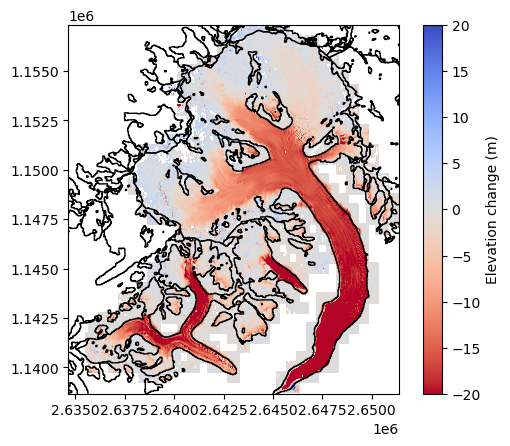

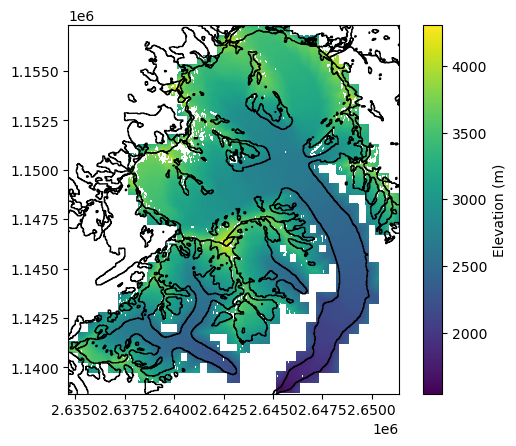

In [4]:
plt.figure()
ax = plt.subplot(111)
dh.show(ax=ax,cmap='coolwarm_r', vmin=-20, vmax=20, cb_title="Elevation change (m)")
glacier_outlines.ds.plot(ax=ax, fc="none", ec="k")
plt.xlim(dh.bounds.left, dh.bounds.right)
plt.ylim(dh.bounds.bottom, dh.bounds.top)

plt.figure()
ax = plt.subplot(111)
ref_dem.show(ax=ax,cmap='viridis', cb_title="Elevation (m)")
glacier_outlines.ds.plot(ax=ax, fc="none", ec="k")
plt.xlim(dh.bounds.left, dh.bounds.right)
plt.ylim(dh.bounds.bottom, dh.bounds.top)

## Empirical variogram and plot

In [5]:
list_models=["Spherical", "Spherical"]

In [6]:
(
    df_empirical_variogram,
    df_model_params,
    spatial_corr_function,
) = xdem.spatialstats.infer_spatial_correlation_from_stable(
    dvalues=dh, list_models=list_models, unstable_mask=glacier_outlines
)

C:\Users\brunbarf\Anaconda3\envs\xdem\lib\site-packages\numpy\lib\nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


## Some results from the variogram fit

In [7]:
df_model_params

,model,range,psill
0,spherical,7.627570,4.142596
0,spherical,23170.475006,3.023204


In [8]:
for spatial_lag in [0, 100, 1000, 10000, 30000]:
    print(
        "Errors are correlated at {:.1f}% for a {:,.0f} m spatial lag".format(
            spatial_corr_function(spatial_lag) * 100, spatial_lag
        )
    )

Errors are correlated at 100.0% for a 0 m spatial lag
Errors are correlated at 41.9% for a 100 m spatial lag
Errors are correlated at 39.5% for a 1,000 m spatial lag
Errors are correlated at 16.6% for a 10,000 m spatial lag
Errors are correlated at 0.0% for a 30,000 m spatial lag


## Plot the variogram

<Figure size 640x480 with 0 Axes>

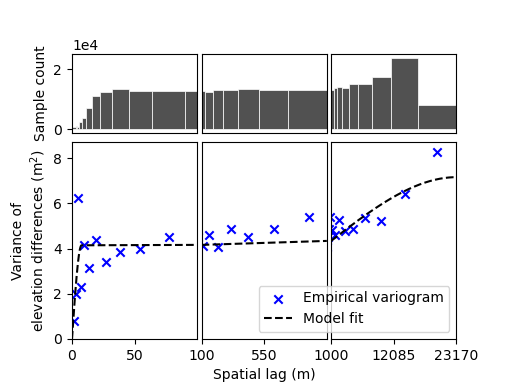

In [9]:
plt.figure()
xdem.spatialstats.plot_variogram(
    df=df_empirical_variogram,
    list_fit_fun=[xdem.spatialstats.get_variogram_model_func(df_model_params)],
    xlabel="Spatial lag (m)",
    ylabel="Variance of\nelevation differences (m$^2$)",
    xscale_range_split=[100,1000],
)

## Estimate heteroscedasticity

### First calculate terrain derivatives (slope, curvature)

In [10]:
slope, maximum_curvature = xdem.terrain.get_terrain_attribute(ref_dem, attribute=["slope", "maximum_curvature"])
errors, df_binning, error_function = xdem.spatialstats.infer_heteroscedasticity_from_stable(
    dvalues=dh, list_var=[slope, maximum_curvature], list_var_names=["slope", "maxc"], unstable_mask=glacier_outlines
)

### Normalize variance and calculate new variogram

In [11]:
zscores = dh / errors
emp_variogram, params_variogram_model, spatial_corr_function = xdem.spatialstats.infer_spatial_correlation_from_stable(
    dvalues=zscores, list_models=list_models, unstable_mask=glacier_outlines
)

### Some results from the variogram fit

In [12]:
params_variogram_model

,model,range,psill
0,spherical,10.534647,2.992366
0,spherical,23170.475006,1.000788


### Plot normalized variogram

<Figure size 640x480 with 0 Axes>

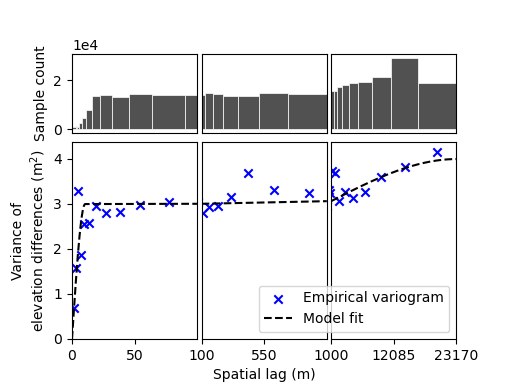

In [13]:
plt.figure()
xdem.spatialstats.plot_variogram(
    df=emp_variogram,
    list_fit_fun=[xdem.spatialstats.get_variogram_model_func(params_variogram_model)],
    xlabel="Spatial lag (m)",
    ylabel="Variance of\nelevation differences (m$^2$)",
    xscale_range_split=[100,1000],
)

## Spatial integration of variance on the target area

Note that the resolution is too high to actually compute on the glacier area and account for heteroscedacity. Instead, we compute only the integrated variance for an equivalent area.

In [14]:
#areas = [
#    glacier_outlines_Hintereis_only.ds[glacier_outlines_Hintereis_only.ds["DN"] == 1]
#]

areas = [
    82207607., ## ALE
    19286099., ## OBE
    7428079., ## MIT
]

stderr_glaciers = xdem.spatialstats.spatial_error_propagation(
    areas=areas, errors=errors, params_variogram_model=params_variogram_model
)

for glacier_name, stderr_gla in [("ALE", stderr_glaciers[0]), ("OBE", stderr_glaciers[1]), ("MIT", stderr_glaciers[2])]:
    print(f"The error (1-sigma) in mean elevation change for {glacier_name} is {stderr_gla:.2f} meters.")

The error (1-sigma) in mean elevation change for ALE is 0.47 meters.
The error (1-sigma) in mean elevation change for OBE is 0.50 meters.
The error (1-sigma) in mean elevation change for MIT is 0.51 meters.
